In [7]:
import matplotlib.pyplot as plt
def plot_behaviers(file_name):
    # plot actions
    file=open(file_name,"r")
    actions=[]
    for line in file.readlines():
        action=line.split(",")
        for a in action:
            actions.append(a)
    lst=[]
    for a in actions:
        b=a.strip('[').strip(']').split(" ")
        lst.append(b)
    action_values=[]
    for l in lst:
        for s in l:
            if (s!='0.' and s!=""):
                    if s!=']':
                        s=s.rstrip("]")
                        action_values.append(float(s))                     
    plt.figure()
    #plit.subplot(1,2,1)
    plt.plot(action_values)

In [8]:
def plot_rewards(file_name):
    f=open(file_name,"r")
    R=[]
    for l in f:
        for r in l.split(','):
            R.append(r)
    Rewards=[]
    for r in R:
        if r!='':
            Rewards.append(float(r))
    plt.plot(Rewards)

In [40]:
f=open("states_01.txt","r")
states=[]
for line in f.readlines():
    s=line.split(",")
    for state in s:
        states.append(state.strip('[ ').rstrip('] '))
states[0]

'9.99609184e+00 -1.42108513e-14  1.77635642e-15 -3.38813098e-21'

### 目前设定  
 #### 奖励函数
 在原有基础上加了飞行方向惩罚，由于高度达到一定阈值后，oz就始终为0.0，只能在起飞之前用于约束，防止过多出现 force_z < 0 的情况  
 ```
 """高度偏离惩罚"""
        reward=-min(abs(self.target_z-pose.position.z),5)
        
        """高度目标奖励"""
        if abs(pose.position.z-self.target_z) < 0.1:
            reward+=100*(self.target_hit)**2+10
            self.target_hit+=1
        
        """飞行方向惩罚"""
        if pose.position.z < self.target_z:           
            reward+=min(0,pose.orientation.z*1e11) 
            
        """阶段结束条件"""
        if timestamp > self.takeoff_limit:
            if pose.position.z < self.target_z:
                done=True
        if pose.position.z > self.height_limit:
            reward-=1300
            done=True
        if timestamp > self.max_duration:
            done=True
 ```  
 #### DDPG模型    
* <div style="color:red"> states取4维  [z,ox,oy,oz]</div>
* soft update 参数 0.001
* gamma 0.99
* Memory   按优先级存储/取样
   * 容量 1000
   * 一次取样量 100
   
* Actor  
   * 优化器 Adam: lr=0.0001  
   * 网络结构 2 hidden-layers(400-300)
   * 激活函数 tanh
* Critic
   * 优化器 Adadelta(默认)
   * l2正则化(10-5)
   * 网络结构 state:（400-300）+ actions:300


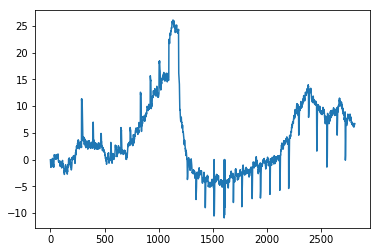

In [53]:
plot_behaviers("actions_01.txt")

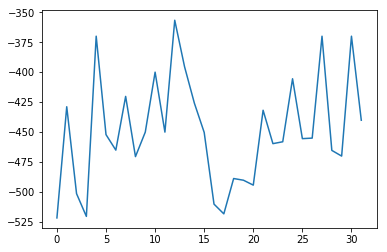

In [54]:
plot_rewards("rewards_01.txt")

#### Actor模型加上批归一化

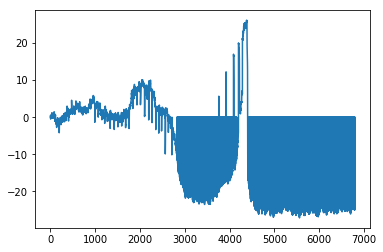

In [63]:
plot_behaviers("actions_02.txt")

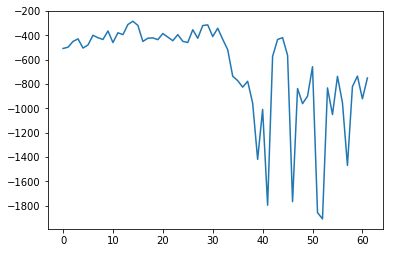

In [64]:
plot_rewards("rewards_02.txt")

#### 奖励函数再调整  
更改飞行方向惩罚力度
```
 """飞行方向惩罚"""
        if pose.position.z < self.target_z:
            if pose.orientation.z!=0.0:
                reward+=min(0,pose.orientation.z/abs(pose.orientation.z)) 
```

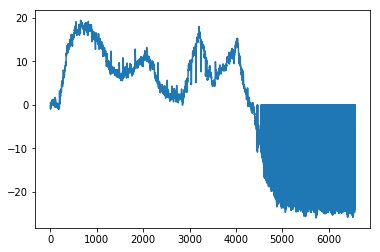

In [66]:
plot_behaviers("actions_03.txt")

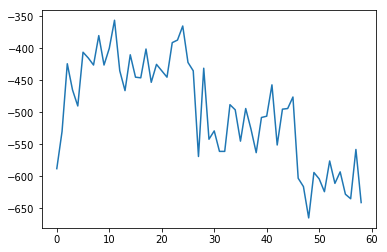

In [67]:
plot_rewards("rewards_03.txt")

* 飞出边界惩罚调至-1000

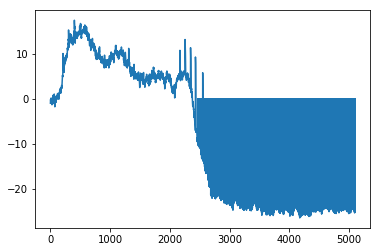

In [68]:
plot_behaviers("actions_04.txt")

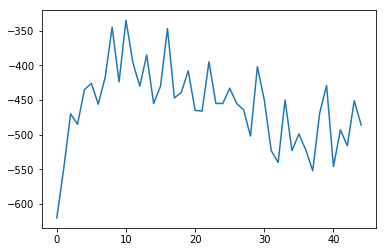

In [69]:
plot_rewards("rewards_04.txt")

* 加大飞行方向惩罚（起飞阶段force_z为持续负值的情况）

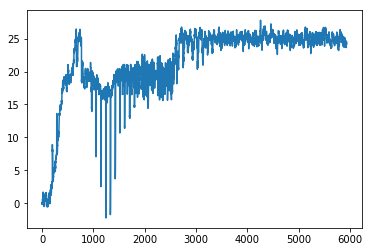

In [70]:
plot_behaviers("actions_05.txt")

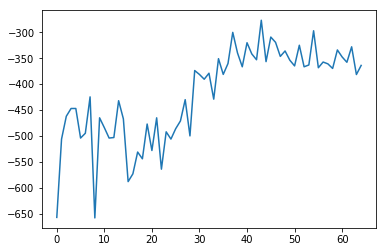

In [71]:
plot_rewards("rewards_05.txt")

* 飞出边界惩罚调回-1300

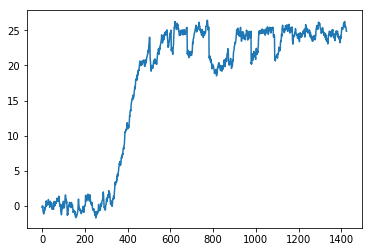

In [72]:
plot_behaviers("actions_06.txt")

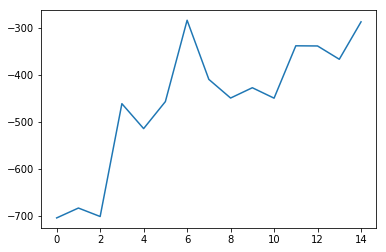

In [73]:
plot_rewards("rewards_06.txt")

#### 奖励函数重新调整  
前半段（height < 10）只施加飞行方向惩罚     

后半段（height > 10）只施加高度偏离惩罚
```
reward=0
        
        if pose.position.z < self.target_z:
        """飞行方向惩罚"""
            if pose.orientation.z!=0.0:
                punish=(pose.orientation.z/abs(pose.orientation.z))*2
                reward+=min(0,punish) 
        else if pose.postion > self.target_z:
        """高度偏离惩罚"""
            reward+=-abs(self.target_z-pose.position.z)
        
        """高度目标奖励"""
        if timestamp > 1: 
            if abs(pose.position.z-self.target_z) < 0.1:
                reward+=100*(self.target_hit)**2+10
                self.target_hit+=1
        
        """阶段结束条件"""
        if timestamp > self.takeoff_limit:
            if pose.position.z < self.target_z:
                done=True
        if pose.position.z > self.height_limit:
            reward-=1300
            done=True
        if timestamp > self.max_duration:
            done=True
```

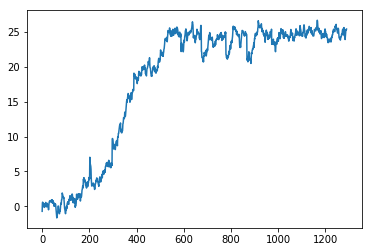

In [74]:
plot_behaviers("actions_07.txt")

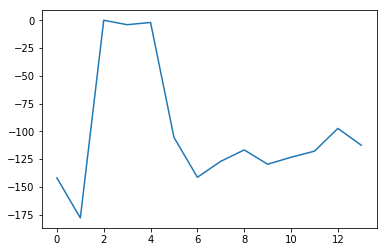

In [75]:
plot_rewards("rewards_07.txt")

* 调整击中高度目标奖励
```
 """高度目标奖励"""
        if timestamp > 1: 
            if abs(pose.position.z-self.target_z) < 0.3:
                self.target_hit+=1
                reward+=10*(self.target_hit)**2
```

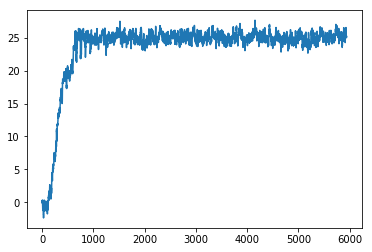

In [76]:
plot_behaviers("actions_08.txt")

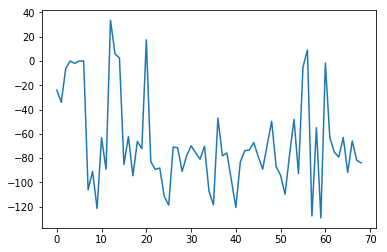

In [77]:
plot_rewards("rewards_08.txt")

* 加大高度偏离惩罚  
```
if pose.position.z < self.target_z:
            """飞行方向惩罚"""
            if pose.orientation.z!=0.0:
                punish=(pose.orientation.z/abs(pose.orientation.z))*2
                reward+=min(0,punish) 
        elif pose.position.z > self.target_z:
            """高度偏离惩罚"""
            reward+=-abs(self.target_z-pose.position.z)*2
```

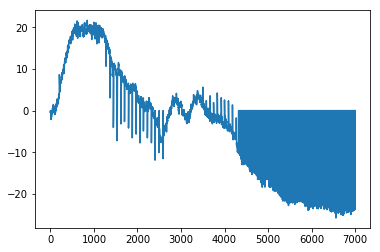

In [78]:
plot_behaviers("actions_09.txt")

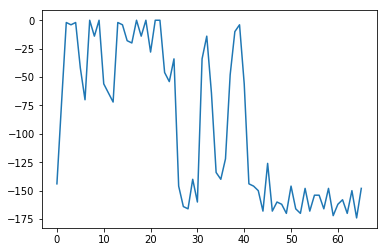

In [79]:
plot_rewards("rewards_09.txt")

* 再次加大惩罚（飞行方向和高度偏离）  
```
 if pose.position.z < self.target_z:
            """飞行方向惩罚"""
            if pose.orientation.z!=0.0:
                punish=(pose.orientation.z/abs(pose.orientation.z))*5
                reward+=min(0,punish) 
        elif pose.position.z > self.target_z:
            """高度偏离惩罚"""
            reward+=-abs(self.target_z-pose.position.z)*5
        
```

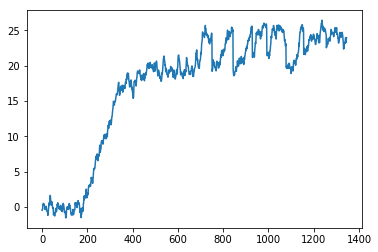

In [80]:
plot_behaviers("actions_10.txt")

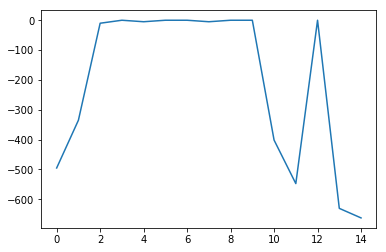

In [81]:
plot_rewards("rewards_10.txt")

* 惩罚重新调整
```
if pose.position.z < self.target_z:
            """飞行方向惩罚"""
            if pose.orientation.z!=0.0:
                punish=(pose.orientation.z/abs(pose.orientation.z))*5
                reward+=min(0,punish) 
        elif pose.position.z > self.target_z:
            """高度偏离惩罚"""
            reward+=-abs(self.target_z-pose.position.z)*10
```
* 取消起飞时间限制，总时间上限调至10s


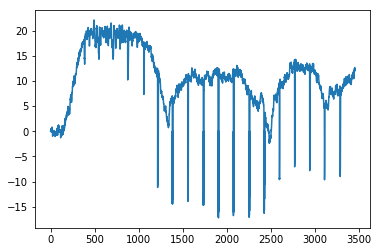

In [82]:
plot_behaviers("actions_11.txt")

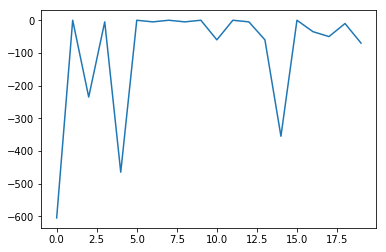

In [83]:
plot_rewards("rewards_11.txt")

* 阶段结束总时间调回15s

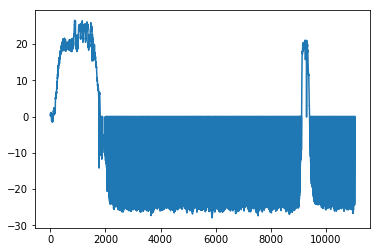

In [84]:
plot_behaviers("actions_12.txt")

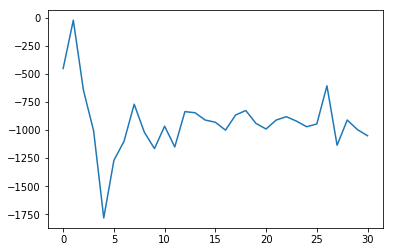

In [85]:
plot_rewards("rewards_12.txt")

* 阶段结束时间调到10s
* 惩罚方案调整，起飞阶段，如果飞行方向向上，加上正奖励  
```
 if pose.position.z < self.target_z:
            """飞行方向惩罚"""
            if pose.orientation.z!=0.0:
                punish=(pose.orientation.z/abs(pose.orientation.z))*5
                reward+=min(1,punish) 
        elif pose.position.z > self.target_z:
            """高度偏离惩罚"""
            reward+=-abs(self.target_z-pose.position.z)*10
        
```

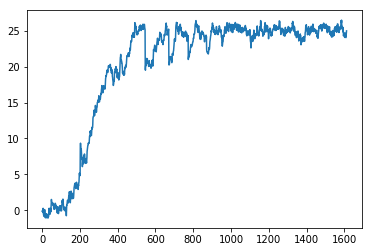

In [86]:
plot_behaviers("actions_13.txt")

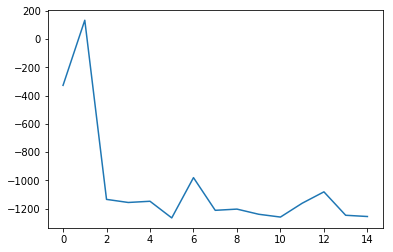

In [87]:
plot_rewards("rewards_13.txt")

* 飞离目标高度惩罚降为-100
* 高度上限设为30
```
reward=0
        
        if pose.position.z < self.target_z:
            """飞行方向惩罚"""
            if pose.orientation.z!=0.0:
                punish=(pose.orientation.z/abs(pose.orientation.z))*5
                reward+=min(1,punish) 
        elif pose.position.z > self.target_z:
            """高度偏离惩罚"""
            reward+=-abs(self.target_z-pose.position.z)*10
        
        """高度目标奖励"""
        if timestamp > 1: 
            if abs(pose.position.z-self.target_z) < 0.3:
                self.target_hit+=1
                reward+=10*(self.target_hit)**2
                
        """阶段结束条件"""
        if pose.position.z > self.height_limit:
            reward-=100
            done=True
        if timestamp > self.max_duration:
            done=True
```

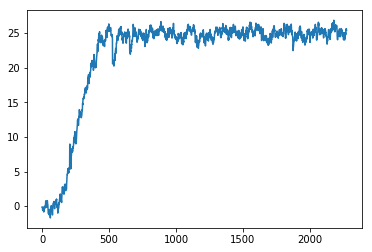

In [88]:
plot_behaviers("actions_14.txt")

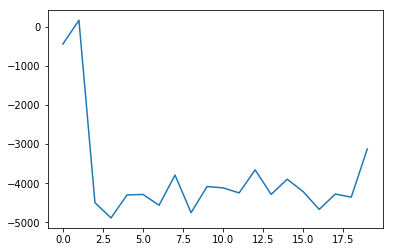

In [89]:
plot_rewards("rewards_14.txt")